In [162]:
import pandas as pd
from glob import glob
import processor
import bioframe as bf
import numpy as np
import bioframe.vis
import matplotlib.pyplot as plt

In [2]:
data_path = '/scratch/groups/horence/angelika/EM_expression/data/'
processed_path = './processed_files/'

In [3]:
glob(data_path+'*')

['/scratch/groups/horence/angelika/EM_expression/data/iso',
 '/scratch/groups/horence/angelika/EM_expression/data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_exon_reads.parquet',
 '/scratch/groups/horence/angelika/EM_expression/data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz',
 '/scratch/groups/horence/angelika/EM_expression/data/gencode.v38.annotation.gff3.gz',
 '/scratch/groups/horence/angelika/EM_expression/data/GTEx_Analysis_2017-06-05_v8_STARv2.5.3a_junctions.gct.gz']

In [77]:
genecode_path = data_path+'gencode.v38.annotation.gff3.gz'
genecode = bf.read_table(genecode_path, schema='gff', skiprows=7)
genecode = genecode[~genecode.start.isna()]
genecode.start = genecode.start.astype(int)
genecode.end = genecode.end.astype(int)

genecode.head()

,chrom,source,feature,start,end,score,strand,frame,attributes
0,chr1,HAVANA,gene,11869,14409,.,+,.,ID=ENSG00000223972.5;gene_id=ENSG00000223972.5...
1,chr1,HAVANA,transcript,11869,14409,.,+,.,ID=ENST00000456328.2;Parent=ENSG00000223972.5;...
2,chr1,HAVANA,exon,11869,12227,.,+,.,ID=exon:ENST00000456328.2:1;Parent=ENST0000045...
3,chr1,HAVANA,exon,12613,12721,.,+,.,ID=exon:ENST00000456328.2:2;Parent=ENST0000045...
4,chr1,HAVANA,exon,13221,14409,.,+,.,ID=exon:ENST00000456328.2:3;Parent=ENST0000045...


In [78]:
glob(processed_path+'*')

['./processed_files/genes_filtered.tsv']

In [79]:
genes = pd.read_csv(processed_path+'genes_filtered.tsv', sep='\t')

In [80]:
genes.head()

,chrom,source,feature,start,end,score,strand,frame,attributes,Description,Name,Parent,counts
0,chr1,HAVANA,gene,141474,173862,.,-,.,ID=ENSG00000241860.7;gene_id=ENSG00000241860.7...,RP11-34P13.13,ENSG00000241860.7,ENSG00000241860.7,6
1,chr1,HAVANA,gene,257864,359681,.,-,.,ID=ENSG00000228463.10;gene_id=ENSG00000228463....,AP006222.1,ENSG00000228463.10,ENSG00000228463.10,6
2,chr1,HAVANA,gene,365389,522928,.,-,.,ID=ENSG00000237094.12;gene_id=ENSG00000237094....,RP4-669L17.4,ENSG00000237094.12,ENSG00000237094.12,25
3,chr1,HAVANA,gene,586071,827796,.,-,.,ID=ENSG00000230021.10;gene_id=ENSG00000230021....,RP11-206L10.17,ENSG00000230021.10,ENSG00000230021.10,15
4,chr1,HAVANA,gene,778747,810065,.,+,.,ID=ENSG00000237491.10;gene_id=ENSG00000237491....,LINC01409,ENSG00000237491.10,ENSG00000237491.10,32


In [81]:
transcripts = processor.get_feature(genecode, 'transcript')
transcripts = pd.merge(transcripts, genes.Name, left_on='Parent', right_on='Name').drop('Name', axis=1)

In [82]:
transcripts.head()

,chrom,source,feature,start,end,score,strand,frame,attributes,Parent,tID
0,chr1,HAVANA,transcript,141474,149707,.,-,.,ID=ENST00000484859.1;Parent=ENSG00000241860.7;...,ENSG00000241860.7,ENST00000484859.1
1,chr1,HAVANA,transcript,142808,146831,.,-,.,ID=ENST00000490997.5;Parent=ENSG00000241860.7;...,ENSG00000241860.7,ENST00000490997.5
2,chr1,HAVANA,transcript,146386,173862,.,-,.,ID=ENST00000466557.6;Parent=ENSG00000241860.7;...,ENSG00000241860.7,ENST00000466557.6
3,chr1,HAVANA,transcript,165491,169210,.,-,.,ID=ENST00000662089.1;Parent=ENSG00000241860.7;...,ENSG00000241860.7,ENST00000662089.1
4,chr1,HAVANA,transcript,165889,168767,.,-,.,ID=ENST00000491962.1;Parent=ENSG00000241860.7;...,ENSG00000241860.7,ENST00000491962.1


In [83]:
exons = processor.get_feature(genecode, 'exon')
exons = pd.merge(exons, transcripts.tID, left_on='Parent', right_on='tID').drop('tID', axis=1)

In [84]:
dummy_gene = 'ENSG00000241860.7'

In [85]:
gtrans= transcripts[transcripts.Parent == dummy_gene]

In [94]:
exons_list = [exons[exons.Parent==tr.tID].iloc[:, :5] for index, tr in gtrans.iterrows()]

In [104]:
exons_list[0]

,chrom,source,feature,start,end
0,chr1,HAVANA,exon,146386,149707
1,chr1,HAVANA,exon,141474,143011


In [187]:
exons_list[1]

,chrom,source,feature,start,end
2,chr1,HAVANA,exon,146642,146831
3,chr1,HAVANA,exon,146386,146509
4,chr1,HAVANA,exon,142808,143011


In [188]:
bf.overlap(exons_list[0], exons_list[1])

,chrom,source,feature,start,end,chrom_,source_,feature_,start_,end_
0,chr1,HAVANA,exon,146386,149707,chr1,HAVANA,exon,146642,146831
1,chr1,HAVANA,exon,146386,149707,chr1,HAVANA,exon,146386,146509
2,chr1,HAVANA,exon,141474,143011,chr1,HAVANA,exon,142808,143011


In [174]:
df1 = pd.DataFrame([
    ['chr1', 1, 5],
    ['chr1', 3, 8],
    ['chr1', 8, 10],
    ['chr1', 12, 14]],
    columns=['chrom', 'start', 'end']
)

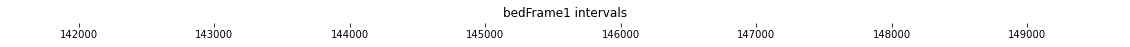

In [186]:
bf.vis.plot_intervals(exons_list[0].drop('source', axis=1).iloc[0:1], show_coords=True, xlim=(141474,149707), figsize=(20, 10))
plt.title('bedFrame1 intervals');

# bf.vis.plot_intervals(exons_list[1], show_coords=True, xlim=(141474,149707), colors='lightpink')
# plt.title('bedFrame2 intervals');

In [150]:
merged_df = bf.merge(pd.concat(exons_list)).drop('n_intervals', axis=1)
merged_df

,chrom,start,end
0,chr1,141474,143011
1,chr1,146386,149707
2,chr1,155767,155831
3,chr1,164263,164791
4,chr1,165491,165942
5,chr1,167129,168165
6,chr1,168610,168767
7,chr1,169049,169264
8,chr1,172557,172688
9,chr1,173753,173862


In [157]:
final_overlap = merged_df
for i, exon_df in enumerate(exons_list):
    current_overlap = bf.overlap(final_overlap, exon_df)
    current_overlap = current_overlap[~current_overlap.start.duplicated()]
    matches = ~current_overlap['start_'].isna()
    current_overlap = current_overlap.iloc[:, np.arange(0, 3+i)]
    current_overlap['exon_'+str(i)] = 0
    current_overlap.loc[matches, 'exon_'+str(i)] =1
    final_overlap = current_overlap
    
final_overlap.iloc[:, 3:] = final_overlap.iloc[:, 3:].astype(int)

In [158]:
final_overlap

,chrom,start,end,exon_0,exon_1,exon_2,exon_3,exon_4,exon_5
0,chr1,141474,143011,1,1,0,0,0,0
1,chr1,146386,149707,1,1,1,0,0,0
2,chr1,155767,155831,0,0,1,0,0,0
3,chr1,164263,164791,0,0,1,0,0,0
4,chr1,165491,165942,0,0,1,1,1,0
5,chr1,167129,168165,0,0,1,1,1,1
6,chr1,168610,168767,0,0,0,0,1,0
7,chr1,169049,169264,0,0,1,1,0,1
8,chr1,172557,172688,0,0,1,0,0,0
9,chr1,173753,173862,0,0,1,0,0,0


In [112]:
first_overlap.start_.isna()

0    False
1    False
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
Name: start_, dtype: bool

In [ ]:
def build_matrix(gene, transcripts, exons):
    gtrans= transcripts[transcripts.Parent == gene]
    for transcript in gtrans:
        